In [1]:
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets

import args
import utils
from networks import LossNetwork, StyleBankNet

"""********Important*******"""
args.continue_training = False # change to your setting
"""************************"""

device = args.device

In [2]:
"""
Load Dataset
"""
content_dataset = datasets.ImageFolder(root=args.CONTENT_IMG_DIR, transform=utils.content_img_transform)
content_dataloader = torch.utils.data.DataLoader(content_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)

style_dataset = datasets.ImageFolder(root=args.STYLE_IMG_DIR, transform=utils.style_img_transform)
style_dataset = torch.cat([img[0].unsqueeze(0) for img in style_dataset], dim=0)
style_dataset = style_dataset.to(device)

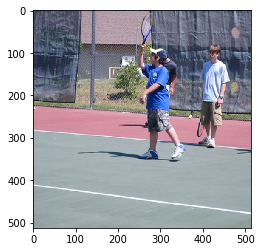

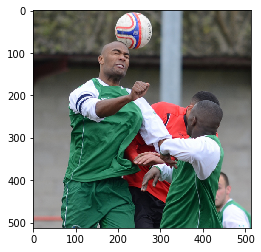

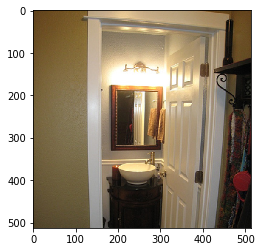

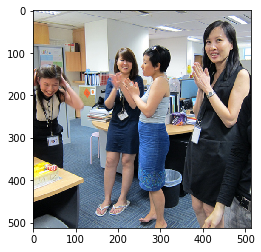

In [3]:
"""
Display content images
"""
for imgs, _ in content_dataloader:
    for i in range(args.batch_size):
        utils.showimg(imgs[i])
    break

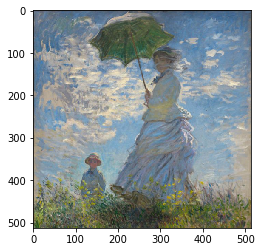

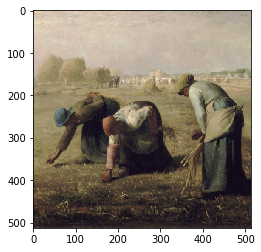

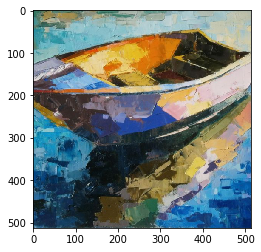

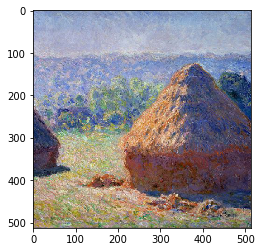

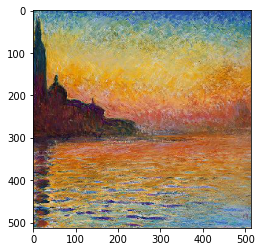

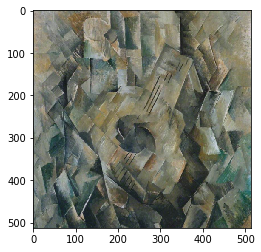

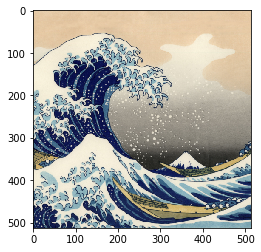

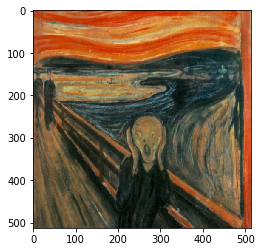

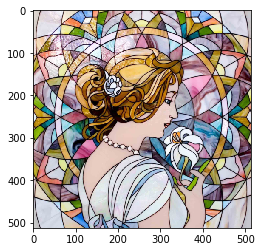

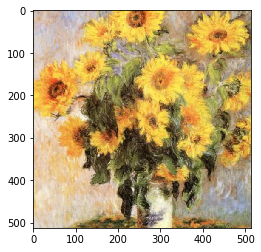

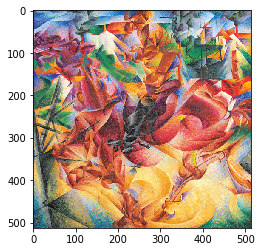

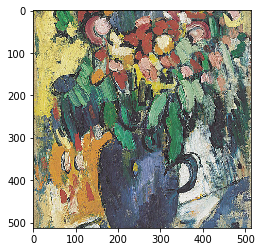

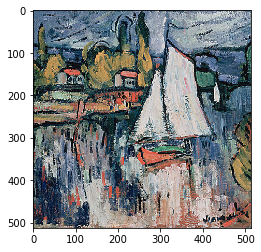

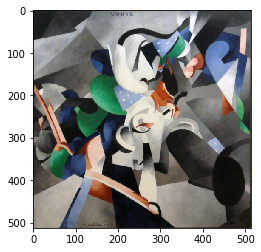

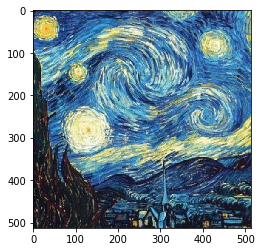

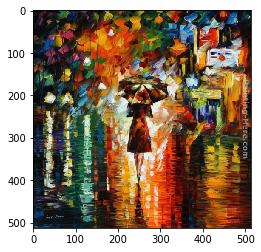

In [4]:
"""
Display style images
"""
for img in style_dataset:
    utils.showimg(img)

In [5]:
"""
Define Model and Loss Network (vgg16)
"""
# style bank net
model = StyleBankNet(len(style_dataset)).to(device)
# 这个支持训练一半中断继续训练
if args.continue_training:
    # 当前训练到第几个step
    if os.path.exists(args.GLOBAL_STEP_PATH):
        with open(args.GLOBAL_STEP_PATH, 'r') as f:
            global_step = int(f.read())
    else:
        raise Exception('cannot find global step file')
    # 权重文件
    if os.path.exists(args.MODEL_WEIGHT_PATH):
        model.load_state_dict(torch.load(args.MODEL_WEIGHT_PATH))
    else:
        raise Exception('cannot find model weights')
else:
    if not os.path.exists(args.MODEL_WEIGHT_DIR):
        os.mkdir(args.MODEL_WEIGHT_DIR)
    if not os.path.exists(args.BANK_WEIGHT_DIR):
        os.mkdir(args.BANK_WEIGHT_DIR)
    global_step = 0
        
optimizer = optim.Adam(model.parameters(), lr=args.lr)
optimizer_ae = optim.Adam(model.parameters(), lr=args.lr)

# 基于vgg的loss network
loss_network = LossNetwork().to(device)

In [6]:
"""
Training
"""

# [0, 1, 2, ..., N]
style_id = list(range(len(style_dataset)))
style_id_idx = 0
style_id_seg = []
for i in range(0, len(style_dataset), args.batch_size):
    style_id_seg.append(style_id[i:i+args.batch_size])
    
s_sum = 0 # sum of style loss
c_sum = 0 # sum of content loss
l_sum = 0 # sum of style+content loss
r_sum = 0 # sum of reconstruction loss
tv_sum = 0 # sum of tv loss

while global_step <= args.MAX_ITERATION:
    for i, data in enumerate(content_dataloader):
        global_step += 1
        data = data[0].to(device)
        batch_size = data.shape[0]
        if global_step % (args.T+1) != 0:
            style_id_idx += 1
            sid = utils.get_sid_batch(style_id_seg[style_id_idx % len(style_id_seg)], batch_size)
            
            optimizer.zero_grad()
            output_image = model(data, sid)
            content_score, style_score = loss_network(output_image, data, style_dataset[sid])
            content_loss = args.CONTENT_WEIGHT * content_score
            style_loss = args.STYLE_WEIGHT * style_score
            
            diff_i = torch.sum(torch.abs(output_image[:, :, :, 1:] - output_image[:, :, :, :-1]))
            diff_j = torch.sum(torch.abs(output_image[:, :, 1:, :] - output_image[:, :, :-1, :]))
            tv_loss = args.REG_WEIGHT*(diff_i + diff_j)
            
            total_loss = content_loss + style_loss + tv_loss
            total_loss.backward()
            optimizer.step()

            l_sum += total_loss.item()
            s_sum += style_loss.item()
            c_sum += content_loss.item()
            tv_sum += tv_loss.item()

        if global_step % (args.T+1) == 0:
            optimizer_ae.zero_grad()
            output_image = model(data)
            loss = F.mse_loss(output_image, data)
            loss.backward()
            optimizer_ae.step()
            r_sum += loss.item()
            
        if global_step % 100 == 0:
            print('.', end='')
            
        if global_step % args.LOG_ITER == 0:
            print("gs: {} {} {:.6f} {:.6f} {:.6f} {:.6f} {:.6f}".format(global_step / args.K, time.strftime("%H:%M:%S"), l_sum / 666, c_sum / 666, s_sum / 666, tv_sum / 666, r_sum / 333))
            r_sum = 0
            s_sum = 0
            c_sum = 0
            l_sum = 0
            tv_sum = 0
            # save whole model (including stylebank)
            torch.save(model.state_dict(), args.MODEL_WEIGHT_PATH)
            # save seperate part
            with open(args.GLOBAL_STEP_PATH, 'w') as f:
                f.write(str(global_step))
            torch.save(model.encoder_net.state_dict(), args.ENCODER_WEIGHT_PATH)
            torch.save(model.decoder_net.state_dict(), args.DECODER_WEIGHT_PATH)
            for i in range(len(style_dataset)):
                torch.save(model.style_bank[i].state_dict(), args.BANK_WEIGHT_PATH.format(i))
            
        if global_step % args.ADJUST_LR_ITER == 0:
            lr_step = global_step / args.ADJUST_LR_ITER
            utils.adjust_learning_rate(optimizer, lr_step)
            new_lr = utils.adjust_learning_rate(optimizer_ae, lr_step)
            
            print("learning rate decay:", new_lr)

..........gs: 1.0 16:24:15 3457.447146 97.548681 3358.175735 1.722783 0.028105
..........gs: 2.0 16:30:24 1744.141635 99.765931 1642.715830 1.659877 0.018475
..........gs: 3.0 16:36:33 1365.547072 100.993746 1262.403278 2.150044 0.016513
..........gs: 4.0 16:42:58 875.489563 103.014810 769.731077 2.743678 0.015447
..........gs: 5.0 16:49:09 610.082217 104.251733 502.736010 3.094475 0.012635
..........gs: 6.0 16:55:18 590.150688 104.214905 482.632749 3.303033 0.011988
..........gs: 7.0 17:01:27 416.722483 105.294680 308.257097 3.170706 0.011168
..........gs: 8.0 17:07:36 439.654144 106.724375 329.561315 3.368454 0.011208
..........gs: 9.0 17:13:45 411.969320 106.561646 302.161044 3.246629 0.010198
..........gs: 10.0 17:19:55 550.207822 107.080060 439.733541 3.394221 0.014103
learning rate decay: 0.0008
..........gs: 11.0 17:26:03 306.770785 107.736143 195.969967 3.064674 0.009410
..........gs: 12.0 17:32:12 970.472184 105.806440 861.445215 3.220529 0.014820
..........gs: 13.0 17:38:21 3

..........gs: 102.0 02:46:06 121.174889 84.100782 34.541965 2.532142 0.003907
..........gs: 103.0 02:52:16 120.265401 83.842633 33.888036 2.534732 0.003468
..........gs: 104.0 02:58:27 120.161392 83.889580 33.739952 2.531860 0.003468
..........gs: 105.0 03:04:37 125.975875 83.267772 40.163522 2.544582 0.003477
..........gs: 106.0 03:10:48 121.530889 84.185042 34.802404 2.543443 0.003660
..........gs: 107.0 03:16:58 119.182548 82.968797 33.681291 2.532460 0.003602
..........gs: 108.0 03:23:09 119.393675 83.050108 33.817974 2.525594 0.003549
..........gs: 109.0 03:29:20 119.284804 82.618323 34.138576 2.527904 0.003563
..........gs: 110.0 03:35:31 119.378938 83.491565 33.359914 2.527459 0.003707
learning rate decay: 8.589934592000005e-05
..........gs: 111.0 03:41:42 118.059890 82.118957 33.421241 2.519692 0.003643
..........gs: 112.0 03:47:53 118.907347 83.184389 33.200148 2.522811 0.003421
..........gs: 113.0 03:54:04 123.281296 81.898212 38.854848 2.528236 0.003664
..........gs: 114.0 0

..........gs: 202.0 13:03:17 111.706773 80.093809 29.135972 2.476993 0.003290
..........gs: 203.0 13:09:26 112.179096 80.334502 29.370307 2.474286 0.003180
..........gs: 204.0 13:15:35 110.667429 79.248192 28.948383 2.470854 0.003247
..........gs: 205.0 13:21:45 111.531450 79.740684 29.314547 2.476218 0.003229
..........gs: 206.0 13:27:54 111.887971 80.268870 29.143962 2.475139 0.003180
..........gs: 207.0 13:34:03 110.864568 79.487768 28.906146 2.470653 0.003234
..........gs: 208.0 13:40:13 111.420585 80.031344 28.913126 2.476115 0.003175
..........gs: 209.0 13:46:22 112.667877 80.527074 29.665459 2.475344 0.003005
..........gs: 210.0 13:52:32 111.688578 79.974734 29.242948 2.470896 0.003235
learning rate decay: 9.223372036854787e-06
..........gs: 211.0 13:58:41 111.408978 79.980113 28.951320 2.477545 0.003133
..........gs: 212.0 14:04:50 111.460955 79.974213 29.012059 2.474683 0.003102
..........gs: 213.0 14:11:09 111.161139 79.592454 29.098567 2.470117 0.003170
..........gs: 214.0 1

Process Process-33:
Process Process-35:
Process Process-34:
Process Process-36:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pro

KeyboardInterrupt: 

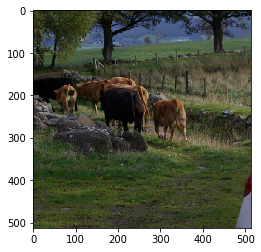

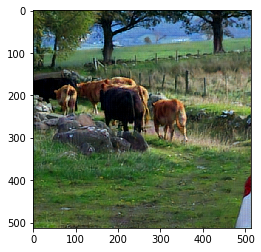

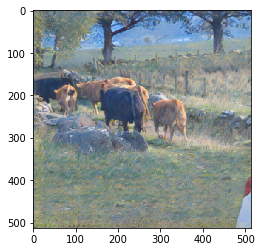

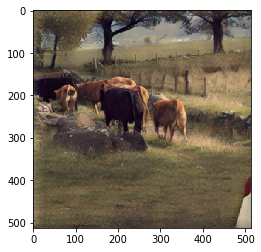

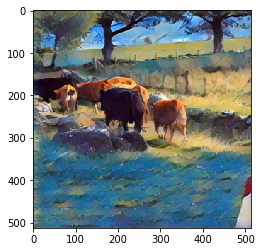

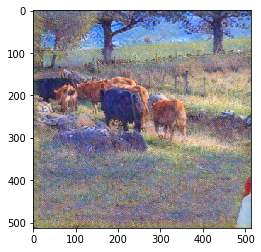

In [13]:
"""
Testing
"""
for i, data in enumerate(content_dataloader, 0):
    data = data[0].to(device)
    batch_size = data.shape[0]
#     data = data[0].repeat(batch_size, 1, 1, 1)
    for j in range(batch_size):
        utils.showimg(data[j].cpu())
    
    output_image = model(data)
    for j in range(batch_size):
        utils.showimg(output_image[j].cpu().detach())
    output_image = model(data, utils.get_sid_batch(style_id_seg[0], batch_size))
    for j in range(batch_size):
        utils.showimg(output_image[j].cpu().detach())
    break